In [29]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as pl
import statsmodels.formula.api as sm
from collections import Counter
from scipy.stats import ttest_ind, ks_2samp
%matplotlib inline

In [2]:
os.listdir('Data/')

['.DS_Store',
 'MetroPopulation.csv',
 'PoliceDataInitiativeParticipants.csv',
 'PostKillingsData.csv',
 'USguncrime.xlsx']

In [3]:
# Load all data in dataframes.
metpop = pd.read_csv('Data/MetroPopulation.csv', thousands=',')
pdi = pd.read_csv('Data/PoliceDataInitiativeParticipants.csv', encoding='latin-1',)
killings = pd.read_csv('Data/PostKillingsData.csv')
guncrime = pd.read_excel('Data/USGunCrime.xlsx', header=3).drop('State', axis=1).rename(columns={'State code': 'State'})
officershootings = ['Fairfax', 'Los Angeles', 'Orlando', 'Atlanta',
                    'Bloomington', 'Louisville', 'Hartford', 'Austin',
                    'Henderson', 'Dallas', 'San Francisco', 'Indianapolis',
                    'Tuscon', 'Knoxville', 'Redondo Beach', 'Cincinnati',
                    'Philadelphia', 'Hampton']

In [4]:
metpop.head()

,Rank,Metropolitan Statistical Area,2010 Census,2000 Census,Growth (%)
0,1,"New York-Northern New Jersey-Long Island, NY-N...",19006798,18323002,3.7
1,2,"Los Angeles-Long Beach-Santa Ana, CA",12872808,12365627,4.1
2,3,"Chicago-Joliet-Naperville, IL-IN-WI",9569624,9098316,5.2
3,4,"Dallas-Fort Worth-Arlington, TX",6300006,5161544,22.1
4,5,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",5838471,5687147,2.7


In [5]:
pdi.head()

,PDI Participant
0,"Albuquerque, NM Police"
1,"Anchorage, AK Police"
2,"Atlanta, GA Police"
3,"Auburn, WA Police"
4,"Austin, TX Police"


In [6]:
killings.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


In [7]:
guncrime.head()

,State,Total murders,"Total firearms murders, 2011","Total firearms murders, 2010","% change, 2010-11",Firearms murders as % of all murders,"Firearms murders per 100,000 population","Firearms robberies per 100,000 pop)","Firearms assaults per 100,000 population"
0,United States,12664,8583,8874.0,-3.279243,67.774795,2.754564,39.250055,43.765898
1,AK,29,16,19.0,-15.789474,55.172414,2.239143,18.193039,80.469212
2,AZ,339,222,232.0,-4.310345,65.486726,3.533977,50.239777,57.355487
3,AR,153,110,93.0,18.279570,71.895425,4.392919,45.446740,100.557901
4,CA,1790,1220,1257.0,-2.943516,68.156425,3.247102,42.973538,45.392895


In [8]:
# Group killings by city.
kcount = killings.groupby('city')['id'].count().sort_values(ascending=False)

# Create standardized city column for pdi & metropolitan population.
pdi = pdi['PDI Participant'].apply(lambda x: pd.Series(x.split(',')))
pdi.columns = ['City', 'is_PDI']
pdi['is_PDI'] = 1

metpop['City'] = metpop['Metropolitan Statistical Area']
metpop['City'] = metpop['Metropolitan Statistical Area'].apply(lambda x: pd.Series(x.split(',')))
metpop['City'] = metpop['City'].apply(lambda x: x.split('-')[0])

metpop['State'] = metpop['Metropolitan Statistical Area']
metpop['State'] = metpop['State'].apply(lambda x: x.split(',')[-1])
metpop['State'] = metpop['State'].apply(lambda x: x.split('-')[0].strip())

In [9]:
# Merge all data.
result = pd.merge(metpop, pdi, on='City', how='outer')
result = pd.merge(result, guncrime, on='State', how='outer')
result[['is_PDI']] = result[['is_PDI']].fillna(value=0)
result = result[np.isfinite(result['2010 Census'])]
result.set_index('City', inplace=True)
result['Killings'] = kcount

# Calculate per capita killings.
result['Killings'] = result['Killings'].fillna(0)
result['KillingsPer100Thou'] = result['Killings'] / (result['2010 Census'] / 100000)

In [13]:
result.head(2)

,Rank,Metropolitan Statistical Area,2010 Census,2000 Census,Growth (%),State,is_PDI,Total murders,"Total firearms murders, 2011","Total firearms murders, 2010","% change, 2010-11",Firearms murders as % of all murders,"Firearms murders per 100,000 population","Firearms robberies per 100,000 pop)","Firearms assaults per 100,000 population",Killings,KillingsPer100Thou
City,,,,,,,,,,,,,,,,,
New York,1.0,"New York-Northern New Jersey-Long Island, NY-N...",19006798.0,18323002.0,3.7,NY,1.0,774,445,517.0,-13.926499,57.49354,4.117524,23.280205,20.060208,8.0,0.042090
Buffalo,47.0,"Buffalo-Niagara Falls, NY",1124309.0,1170111.0,-3.9,NY,0.0,774,445,517.0,-13.926499,57.49354,4.117524,23.280205,20.060208,1.0,0.088944


In [11]:
# Split data based on participation in pdi.
nonpart = result[result['is_PDI'] == 0]
part = result[result['is_PDI'] == 1]

# Take large cities.
nonpartM = nonpart[nonpart['2010 Census'] > 1000000]
partM = part[part['2010 Census'] > 1000000]

# Officer shooting participation.
ospart = result[result.index.isin(officershootings)]
osnonpart = result[~result.index.isin(officershootings)]

# Officer shooting participation for only large cities.
osnonpartM = osnonpart[osnonpart['2010 Census'] > 1000000]
ospartM = ospart[ospart['2010 Census'] > 1000000]

# Officer shooting participation for only small cities.
osnonpartNM = osnonpart[osnonpart['2010 Census'] < 1000000]
ospartNM = ospart[ospart['2010 Census'] < 1000000]

# Statistical Tests.
# All data
print('All data (Killings per 100 Thousand Residents):')
print('Participants: Mean {}'.format(round(part['KillingsPer100Thou'].mean(), 2)))
print('Non-participants: Mean {}'.format(round(nonpart['KillingsPer100Thou'].mean(), 2)))
print(ttest_ind(nonpart['KillingsPer100Thou'], part['KillingsPer100Thou']))
print(ks_2samp(nonpart['KillingsPer100Thou'], part['KillingsPer100Thou']))

# Metro areas > 1M
print('\nMetro Areas with Pop > 1M (Killings per 100 Thousand Residents):')
print('Participants: Mean {}'.format(round(partM['KillingsPer100Thou'].mean(), 2)))
print('Non-participants: Mean {}'.format(round(nonpartM['KillingsPer100Thou'].mean(), 2)))
print(ttest_ind(nonpartM['KillingsPer100Thou'], partM['KillingsPer100Thou']))
print(ks_2samp(nonpartM['KillingsPer100Thou'], partM['KillingsPer100Thou']))

# Report officer involved shootings.
print('\nSpecifically Report Officer Involved Shootings (Killings per 100 Thousand Residents):')
print('Participants: Mean {}'.format(round(ospart['KillingsPer100Thou'].mean(), 2)))
print('Non-participants: Mean {}'.format(round(osnonpart['KillingsPer100Thou'].mean(), 2)))
print(ttest_ind(osnonpart['KillingsPer100Thou'], ospart['KillingsPer100Thou']))
print(ks_2samp(osnonpart['KillingsPer100Thou'], ospart['KillingsPer100Thou']))

# Report officer involved shootings metro areas > 1M
print('\nSpecifically Report Officer Involved Shootings, Metro Areas with Pop > 1M (Killings per 100 Thousand Residents):')
print('Participants: Mean {}'.format(round(ospartM['KillingsPer100Thou'].mean(), 2)))
print('Non-participants: Mean {}'.format(round(osnonpartM['KillingsPer100Thou'].mean(), 2)))
print(ttest_ind(osnonpartM['KillingsPer100Thou'], ospartM['KillingsPer100Thou']))
print(ks_2samp(osnonpartM['KillingsPer100Thou'], ospartM['KillingsPer100Thou']))

All data (Killings per 100 Thousand Residents):
Participants: Mean 0.36
Non-participants: Mean 0.39
Ttest_indResult(statistic=0.47499103280454535, pvalue=0.63583958474638469)
Ks_2sampResult(statistic=0.14452798663324984, pvalue=0.67057310434701256)

Metro Areas with Pop > 1M (Killings per 100 Thousand Residents):
Participants: Mean 0.31
Non-participants: Mean 0.33
Ttest_indResult(statistic=0.33506132708424546, pvalue=0.73898051601333337)
Ks_2sampResult(statistic=0.16897081413210446, pvalue=0.83188009534273188)

Specifically Report Officer Involved Shootings (Killings per 100 Thousand Residents):
Participants: Mean 0.31
Non-participants: Mean 0.39
Ttest_indResult(statistic=0.75313175250133646, pvalue=0.4531580168728)
Ks_2sampResult(statistic=0.25151515151515158, pvalue=0.50174418964864875)

Specifically Report Officer Involved Shootings, Metro Areas with Pop > 1M (Killings per 100 Thousand Residents):
Participants: Mean 0.31
Non-participants: Mean 0.32
Ttest_indResult(statistic=0.119407

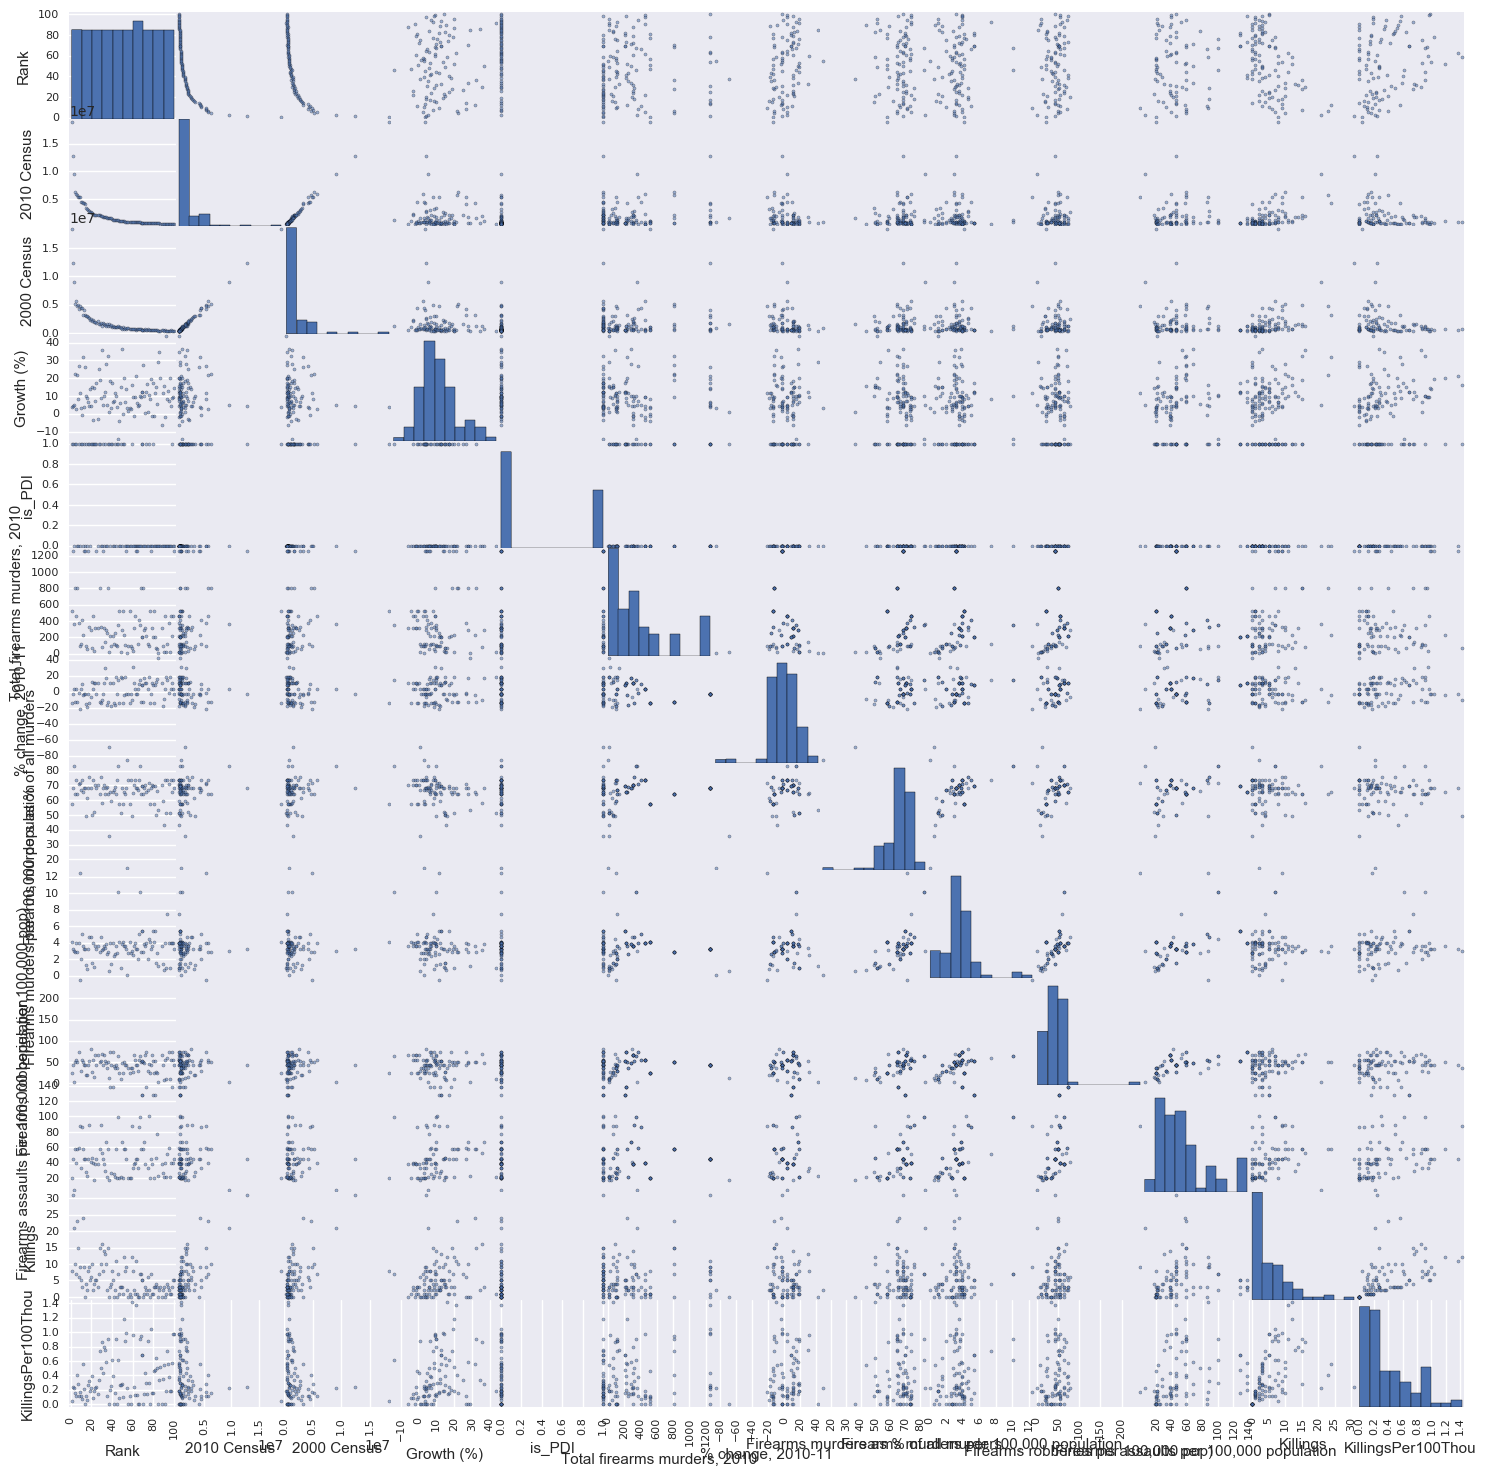

In [23]:
sm = pd.scatter_matrix(result, figsize=(18, 18))

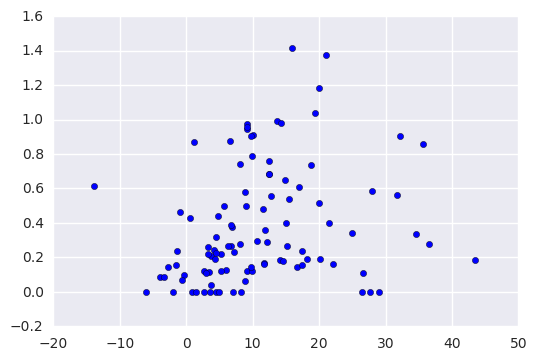

In [27]:
pl.scatter(result['Growth (%)'], result.KillingsPer100Thou)

In [ ]:
reg1 = sm.ols('KillingsPer100Thou ~ Growth (%)', data=result).fit()

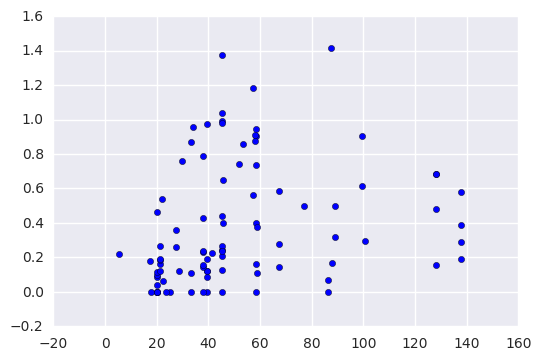

In [28]:
pl.scatter(result['Firearms assaults per 100,000 population'], result.KillingsPer100Thou)